In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

from tools import COLUMNS_QUANT
## VS Code, choisir un seul des 3 :

# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
%config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv')
df.columns

Index(['day', 'hashed_partner_id', 'hashed_campaign_id', 'contextid',
       'display_env', 'target_env', 'rtbtypeid', 'rtbadvisibility',
       'rtb_detectedlanguage', 'urlhash2', 'urlhash3', 'urlhash4',
       'user_country', 'hashed_affiliateid', 'hashed_app_id',
       'googleviewability', 'googlepagevertical', 'campaignscenario',
       'campaignvertical', 'campaignctrlast24h', 'is_interstitial',
       'dayssincelastvisitdouble', 'ltf_lastpartnerclicktimestamp',
       'ltf_nbglobalclick_4w', 'ltf_nbglobaldisplay_4w',
       'ltf_nbglobaldisplaysincelastpartnerproductview',
       'ltf_nbpartnerdisplayssincelastclick', 'ltf_nbpartnerclick_4w',
       'ltf_nbpartnerdisplay_4w', 'ltf_nbpartnersales_4w',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplaypartnerapprox_1d_sum_xdevice',
       'nbdisplayaffiliateapprox_1d_sum_xdevice',
       'nbdisplayglobalapprox_1d_sum_xdevice', '

In [3]:
# On mélange car on pourra afficher autant de clics que de non-clics
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
# On conserve nos 13 variables quantitatives et la variable cible. 
df_acp = df[COLUMNS_QUANT + ['is_display_clicked']]
df_acp = df_acp.dropna().reset_index(drop=True)

In [5]:
colors = np.array(['r' if (df_acp['is_display_clicked'][i] == 0) else 'g' for i in range(len(df_acp))])
df_acp = df_acp.drop(['is_display_clicked'], axis=1)

In [6]:
len(df_acp) / len(df)

1.0

In [7]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
Z

array([[-1.92104218, -0.09584886, -0.44867976, ...,  0.13604243,
        -0.68459631, -0.36603538],
       [-0.26521992,  0.09831617,  0.76716911, ..., -0.33602326,
        -0.519958  , -0.34094021],
       [-0.67917548, -0.97223658,  6.26288384, ..., -0.44493026,
        -0.84923462, -0.34882957],
       ...,
       [ 0.14873565, -0.47241629, -0.30643517, ...,  0.30857429,
         1.0029464 , -0.18047169],
       [-1.92104218,  0.15181968, -0.44867976, ...,  0.63836838,
        -0.6269729 , -0.36705589],
       [ 0.56269122,  0.05880094,  0.35479208, ..., -0.53090159,
        -0.07749253, -0.36541297]])

In [8]:
acp = PCA(svd_solver='full')

In [9]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

13


In [10]:
print(acp.explained_variance_ratio_)

[0.18012345 0.10174326 0.09839119 0.09143027 0.08430513 0.0829938
 0.06881806 0.06201962 0.05988671 0.05678244 0.05055044 0.04220246
 0.02075318]


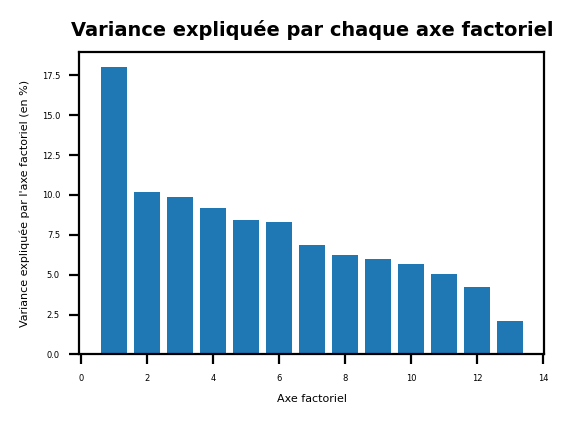

In [11]:
plt.rc('xtick', labelsize=3)
plt.rc('ytick', labelsize=3)
plt.figure(figsize=(3, 2), dpi=200)
plt.bar(np.arange(1, acp.n_components_ + 1), acp.explained_variance_ratio_ * 100)
plt.title("Variance expliquée par chaque axe factoriel", size=7, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=4)
plt.xlabel("Axe factoriel", size=4)
plt.show()

In [12]:
coord_not_cliqued = [ [] for _ in range(acp.n_components_)]
coord_cliqued = [ [] for _ in range(acp.n_components_)]

for i in range(len(coord[:,0])):
    if df['is_display_clicked'][i] == 0:
        for j in range(acp.n_components_):
            coord_not_cliqued[j].append(coord[i,j])
    else:
        for j in range(acp.n_components_):
            coord_cliqued[j].append(coord[i,j])

In [13]:
def distributions_sur_axe(axe_factoriel):
    s = pd.Series(coord_cliqued[axe_factoriel-1])
    s_not = pd.Series(coord_not_cliqued[axe_factoriel-1])
    fig, ax = plt.subplots(figsize=(4,2), dpi=225)
    ax.set_xlim(max(s.min(), s_not.min()), min(s.max(), s_not.max()))
    s.plot.kde(ax=ax, linewidth=0.5)
    s_not.plot.kde(ax=ax, linewidth=0.5)
    plt.rc('xtick', labelsize=3)
    plt.rc('ytick', labelsize=3)
    plt.title(f"Distribution des observations sur l'axe {axe_factoriel} selon le clic", size=5)
    plt.legend(['Clic','Pas clic'], prop={'size': 5})
    plt.ylabel("")
    plt.show()

Voici les distribustions sur les axes les plus pertinents.

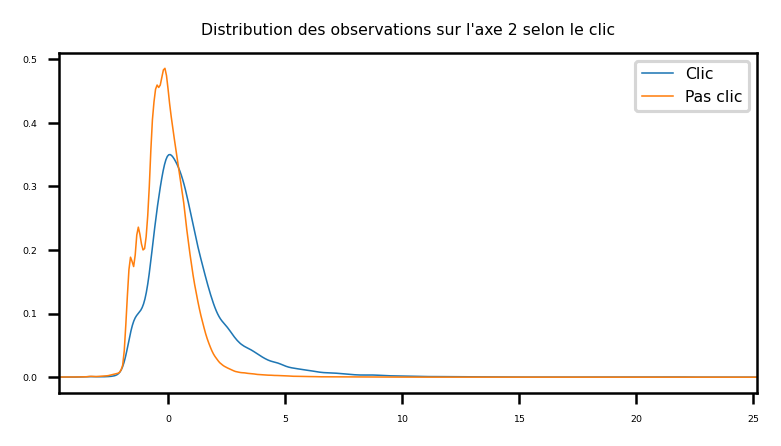

In [14]:
distributions_sur_axe(2)

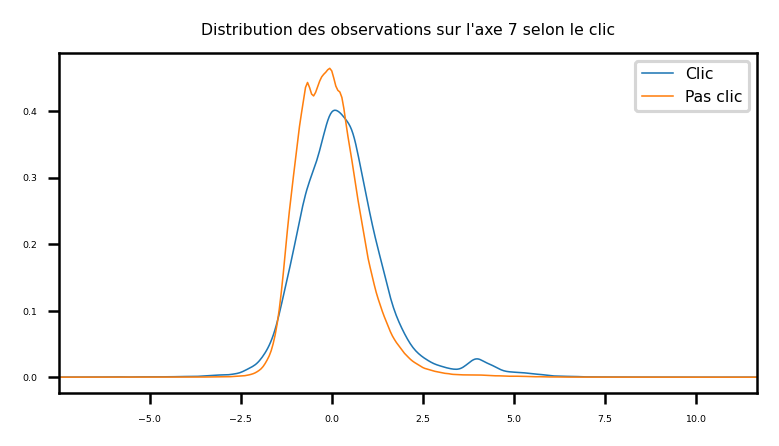

In [15]:
distributions_sur_axe(7)

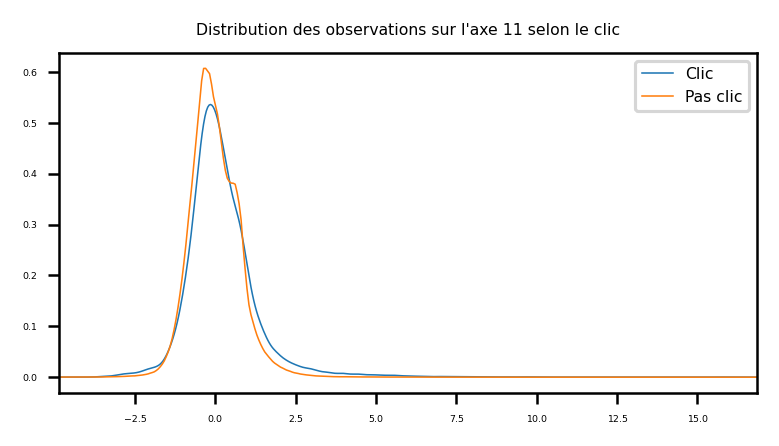

In [16]:
distributions_sur_axe(11)

In [17]:
def affichage_plan_factoriel_equal(i, j, pourcentage=1, equal=False, markersize=0.5, alpha=1, verbose=False):
    """
    pourcentage: proprotion de points à afficher
    equal: si True, autant de points rouges que de points verts
    """
    plt.figure(figsize=(3,2), dpi=225)

    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)   

    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])
        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

       # N_not = int(1/pourcentage)
       # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    plt.scatter(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], marker='.', color='g', linewidths=0, s=markersize, alpha=alpha)
    plt.scatter(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], marker='.', color='r', linewidths=0, s=markersize, alpha=alpha)
    plt.xlabel(f'Axe {i}', size=4)
    plt.ylabel(f'Axe {j}', size=4)
    plt.title(f'Plan (Axe {i}, Axe {j})', size=5)
    legend = plt.legend(['Pas cliqué', 'Cliqué'], prop={'size': 5})
    for lh in legend.legendHandles:
        lh.set_alpha(1.0)
        lh.set_sizes([5])
    plt.show()
    # plt.savefig('plan_axe1_axe2.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
    # plt.close()
    plt.show()

def affichage_plan_factoriel(i,j):
    plt.figure(figsize=(6,4))
    plt.xlabel(f'Axe {i}')
    plt.ylabel(f'Axe {j}')
    plt.title(f'Plan (Axe {i}, Axe {j})')
    plt.scatter(coord[:,i-1], coord[:,j-1], c=colors, marker=".", s=0.75)
    plt.show()

Dans le plan (2, 7) les clics sont au nord-est et à l'est (légèrement sud).

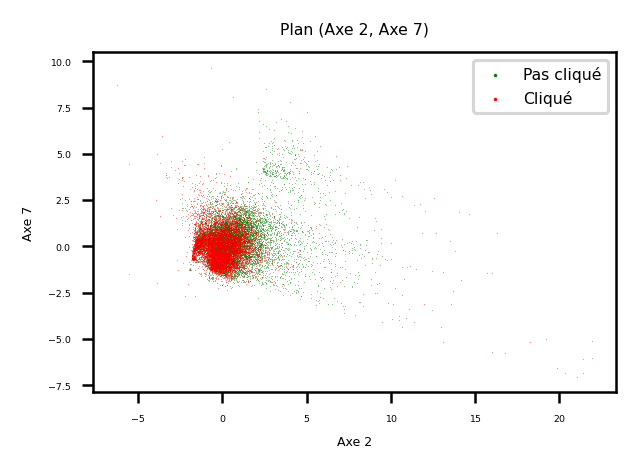

In [18]:
affichage_plan_factoriel_equal(2, 7, pourcentage=0.1, markersize=0.5, alpha=0.5, equal=True)

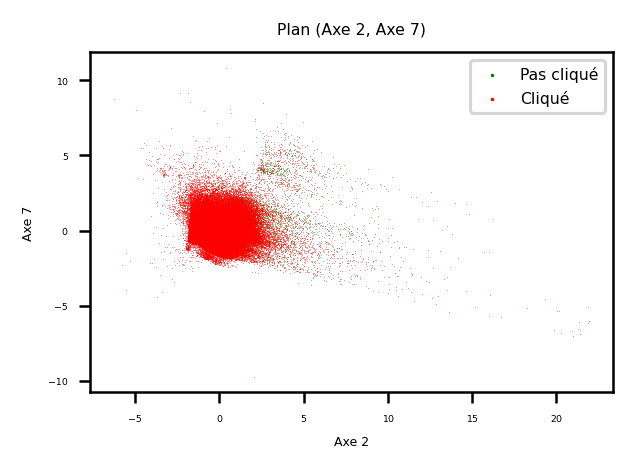

In [19]:
affichage_plan_factoriel_equal(2, 7, pourcentage=0.1, markersize=0.5, alpha=0.5, equal=False)

Dans le plan (2, 11), les clics sont dirigés selon un axe nord-est et un peu à l'est (légèrement au sud).

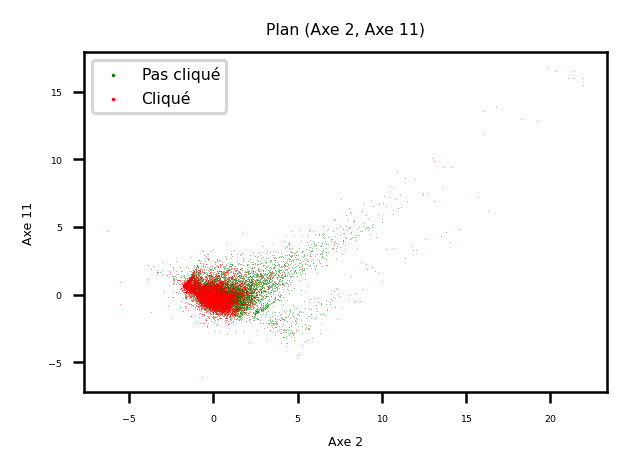

In [20]:
affichage_plan_factoriel_equal(2, 11, pourcentage=0.1, markersize=0.5, alpha=0.5, equal=True)

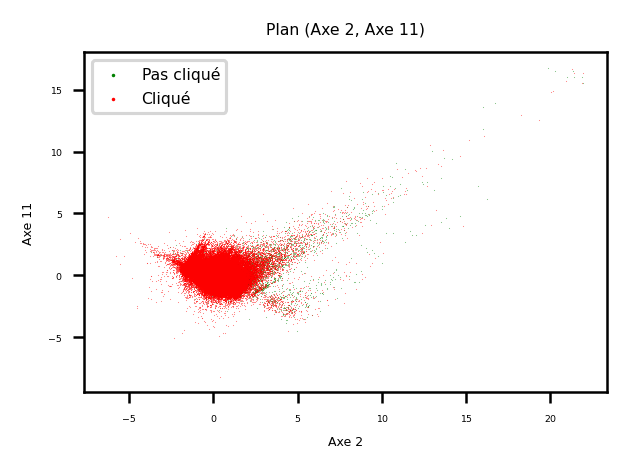

In [21]:
affichage_plan_factoriel_equal(2, 11, pourcentage=0.1, markersize=0.5, alpha=0.5, equal=False)

Dans le plan (7, 11), les clics sont au nord-ouest et un peu à l'est.

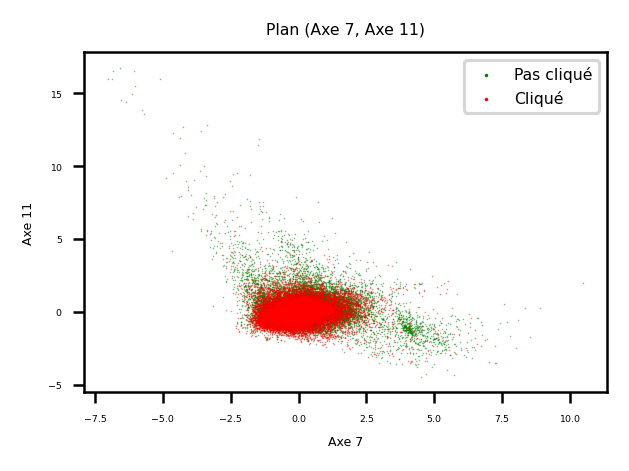

In [22]:
affichage_plan_factoriel_equal(7, 11, pourcentage=0.2, markersize=1, alpha=0.5, equal=True)

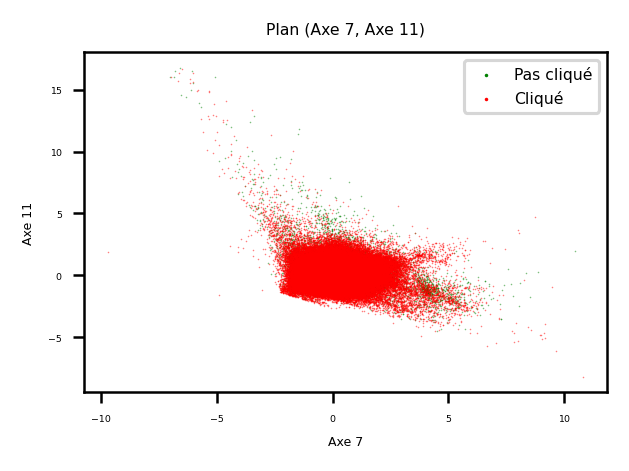

In [23]:
affichage_plan_factoriel_equal(7, 11, pourcentage=0.2, markersize=1, alpha=0.5, equal=False)

In [24]:
# calcul des corrélations
n = len(df_acp)
p = len(df_acp.columns)

eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

In [25]:
def correlations_sur_axe(axe_factoriel):
    plt.figure(figsize=(3,2), dpi=200)
    plt.rc('xtick', labelsize=3)
    plt.rc('ytick', labelsize=4)
    plt.xticks(rotation=45)
    plt.bar(np.arange(1,acp.n_components_+1), corvar[:,axe_factoriel-1], tick_label=df_acp.columns)
    plt.title(f"Corrélations sur l'axe {axe_factoriel}", size=7, fontweight='bold')
    plt.ylabel(f"Corr(Variable, Axe factoriel {axe_factoriel})", size=6)
    plt.xlabel("Variable", size=6)
    plt.show()

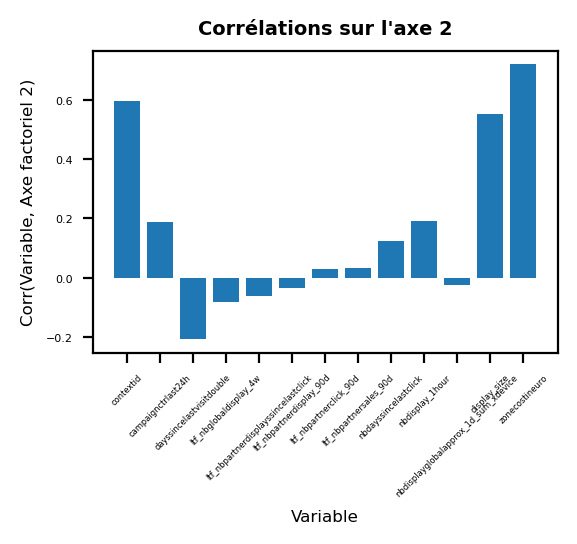

In [26]:
correlations_sur_axe(2)

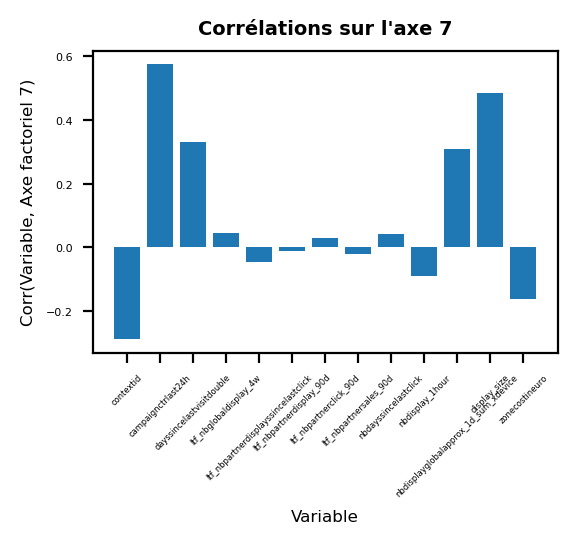

In [27]:
correlations_sur_axe(7)

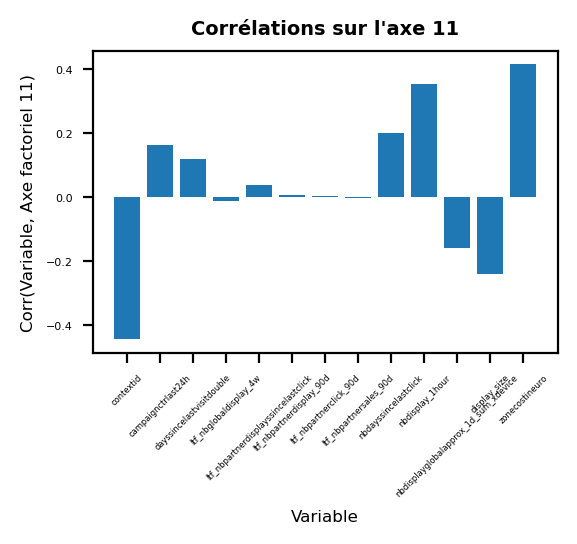

In [28]:
correlations_sur_axe(11)

In [29]:
def affichage_cercle_corr(ax1, ax2):
    fig, axes = plt.subplots(figsize=(3,3), dpi=200)
    axes.set_xlim(-1.05, 1.05)
    axes.set_ylim(-1.05, 1.05)

    for j in range(p):
        axes.arrow(0, 0, corvar[j,ax1-1], corvar[j,ax2-1], head_width=0.005, head_length=0.01, fc='grey', ec='grey')
        plt.annotate(df_acp.columns[j], (corvar[j,ax1-1],corvar[j,ax2-1]), size=4, color='r')

    plt.plot([-1, 1], [0, 0],color='silver', linestyle='-', linewidth=1)
    plt.plot([0, 0], [-1, 1],color='silver', linestyle='-', linewidth=1)

    cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
    axes.add_artist(cercle)

    plt.show()

Dans le plan (2, 7), le nord-est et l'est (légèrement au sud) correspondent à deux couples de variables : la taille de la pub et la performance de la campagne d'une part, le coût de l'empacement publicitaire et l'engagement de l'utilisateur d'autre part.
Ces quatre variables semblent avoir un effet significatif et positif sur la propension à cliquer des utilisateurs.

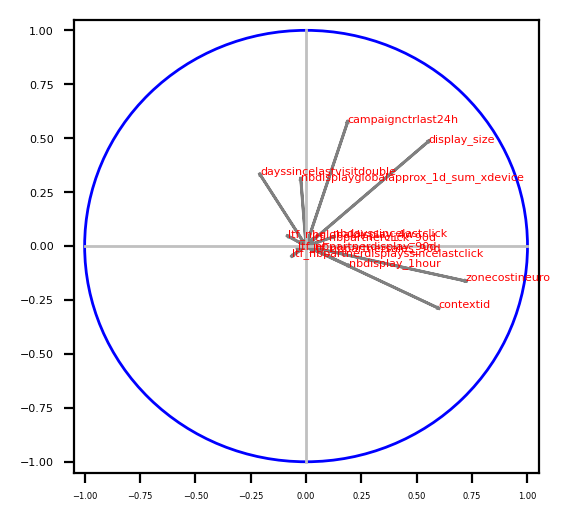

In [30]:
affichage_cercle_corr(2,7)

La forme du nuage de point dans le plan (2, 11) est clairement guidée par le coût de l'emplacement publicitaire. Cette variable semble être d'autant plus importante.
En plus des variables remarquées grâce au plan (2, 7), le nombre de fois que la publicité s'est affichée à l'utilisateur durant la dernière heure semble avoir un (faible) effet positif sur le clic.

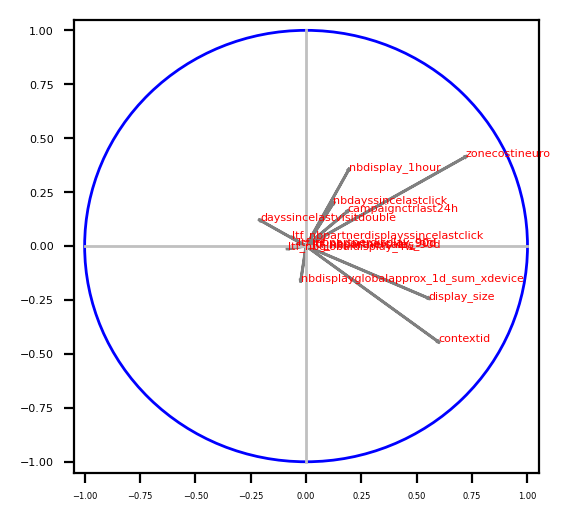

In [31]:
affichage_cercle_corr(2, 11)

Dans le plan (7, 11), on identifie encore un role (faiblement) positif sur les clics pour le coût de l'emplacement et le nombre d'affichage durant la dernière heure.

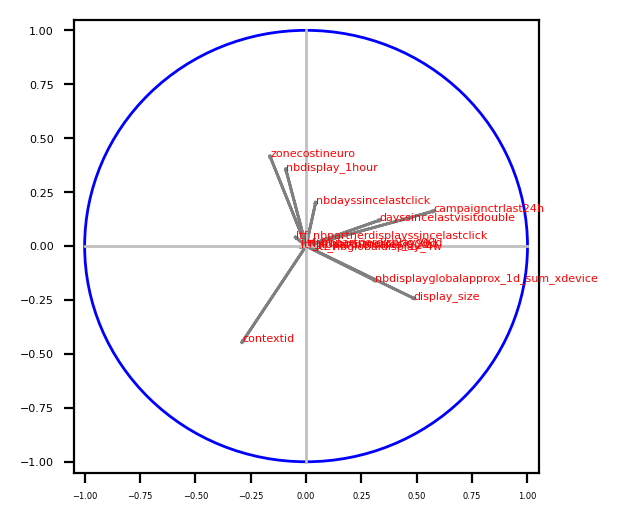

In [32]:
affichage_cercle_corr(7, 11)

In [33]:
def affichage_3d_factoriel(i, j, k, pourcentage=1, equal=False, markersize=1, verbose=False, alpha=1):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)
    
    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])

        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

        # N_not = int(1/pourcentage)
        # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    ax.scatter(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], coord_cliqued[k-1][::N], s=markersize, color='g', linewidths=0, marker='o', alpha=alpha)
    ax.scatter(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], coord_not_cliqued[k-1][::N_not], s=markersize, color='r', linewidths=0, marker='o', alpha=alpha)
    ax.set_xlabel(f'Axe {i}')
    ax.set_ylabel(f'Axe {j}')
    ax.set_zlabel(f'Axe {k}')
    plt.title(f'Plan (Axe {i}, Axe {j}, Axe {k})')
    legend = plt.legend(['Pas cliqué', 'Cliqué'])
    for lh in legend.legendHandles:
        lh.set_alpha(1.0)
        lh.set_sizes([30])
    plt.show()

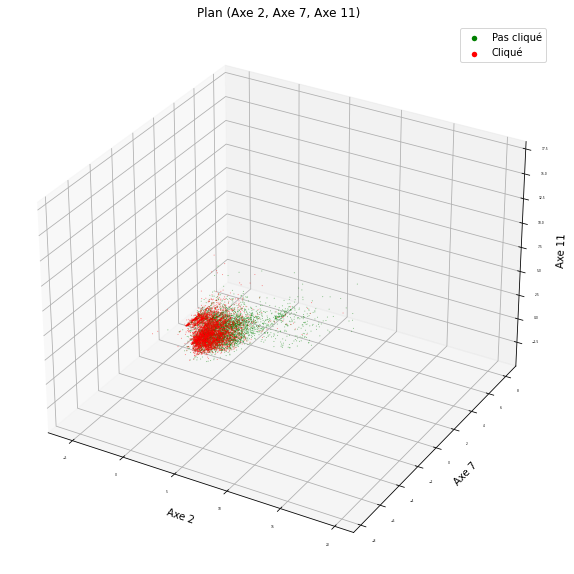

In [34]:
affichage_3d_factoriel(2, 7, 11, pourcentage=0.05, markersize=1, alpha=0.5, equal=True)

In [35]:
%matplotlib widget
affichage_3d_factoriel(2, 7, 11, pourcentage=0.05, markersize=1, alpha=0.5, equal=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
%matplotlib inline

In [37]:
def sphere_correlations(axe1, axe2, axe3):
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)

    ax.add_line(plt3d.art3d.Line3D([-1,1], [0,0], [0,0]))
    ax.add_artist(plt3d.art3d.Text3D(x=1, y=0, z=0, text=f"Axe {axe1}", zdir='x', size=8))

    ax.add_line(plt3d.art3d.Line3D([0,0], [-1,1], [0,0]))
    ax.add_artist(plt3d.art3d.Text3D(x=0, y=1, z=0, text=f"Axe {axe2}", zdir='y', size=8))

    ax.add_line(plt3d.art3d.Line3D([0,0], [0,0], [-1,1]))
    ax.add_artist(plt3d.art3d.Text3D(x=0, y=0, z=1, text=f"Axe {axe3}", zdir='z', size=8))

    ax.quiver(np.zeros(p), np.zeros(p), np.zeros(p), corvar[:,axe1-1], corvar[:,axe2-1], corvar[:,axe3-1], color='r')
    for i in range(p):
        ax.add_artist(plt3d.art3d.Text3D(x=corvar[i,axe1-1], y=corvar[i,axe2-1], z=corvar[i,axe3-1], text=df_acp.columns[i], zdir=(corvar[i,axe1-1], corvar[i,axe2-1], corvar[i,axe3-1]), size=6))


    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])

    plt.show()

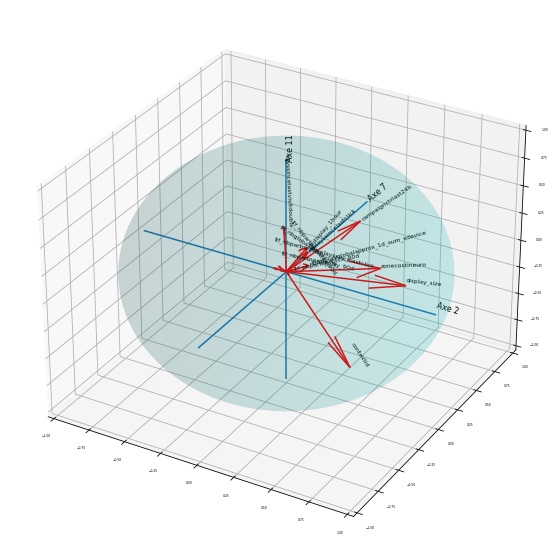

In [38]:
sphere_correlations(2, 7, 11)

In [39]:
%matplotlib widget
sphere_correlations(2, 7, 11)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [40]:
%matplotlib inline

## Bilan

Variables semblant avoir un effet positif significatif : display_size, campaignctrllast24h, zonecostineuro, contextid.
Variable semblant avoir un effet positif faible : nbdisplay_1hour.

In [41]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:04:36
